# import libraries


In [1]:
import os
import h5py
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
from skimage.filters import sobel
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Dounload dataset and unzip it.
!wget "https://figshare.com/ndownloader/articles/1512427/versions/5"
!unzip /content/5 -d /content/Files

--2023-09-03 10:19:54--  https://figshare.com/ndownloader/articles/1512427/versions/5
Resolving figshare.com (figshare.com)... 34.240.93.252, 52.18.6.175, 2a05:d018:1f4:d000:5548:2e8a:5e77:8f2f, ...
Connecting to figshare.com (figshare.com)|34.240.93.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879501695 (839M) [application/zip]
Saving to: ‘5’

5                   100%[===================>] 838.76M  27.9MB/s    in 31s     

2023-09-03 10:20:25 (27.1 MB/s) - ‘5’ saved [879501695/879501695]

Archive:  /content/5
 extracting: /content/Files/brainTumorDataPublic_1-766.zip  
 extracting: /content/Files/brainTumorDataPublic_1533-2298.zip  
 extracting: /content/Files/brainTumorDataPublic_767-1532.zip  
 extracting: /content/Files/brainTumorDataPublic_2299-3064.zip  
 extracting: /content/Files/cvind.mat  
 extracting: /content/Files/README.txt  


In [3]:
# Make folder
os.mkdir("data")
# Unzip the zip files to the folder.
!unzip Files/brainTumorDataPublic_1-766.zip -d data
!unzip Files/brainTumorDataPublic_767-1532.zip -d data
!unzip Files/brainTumorDataPublic_1533-2298.zip -d data
!unzip Files/brainTumorDataPublic_2299-3064.zip -d data

Archive:  Files/brainTumorDataPublic_1-766.zip
  inflating: data/1.mat              
  inflating: data/10.mat             
  inflating: data/100.mat            
  inflating: data/101.mat            
  inflating: data/102.mat            
  inflating: data/103.mat            
  inflating: data/104.mat            
  inflating: data/105.mat            
  inflating: data/106.mat            
  inflating: data/107.mat            
  inflating: data/108.mat            
  inflating: data/109.mat            
  inflating: data/11.mat             
  inflating: data/110.mat            
  inflating: data/111.mat            
  inflating: data/112.mat            
  inflating: data/113.mat            
  inflating: data/114.mat            
  inflating: data/115.mat            
  inflating: data/116.mat            
  inflating: data/117.mat            
  inflating: data/118.mat            
  inflating: data/119.mat            
  inflating: data/12.mat             
  inflating: data/120.mat            
  i

In [4]:
# For each .mat file, extract the information we want.
def Extract_Info (paths):
  images = []
  masks = []
  labels = []
  for path in paths:
    full_path = os.path.join("data", path)
    mat_file = h5py.File(full_path)
    full_info = mat_file["cjdata"]
    images.append(np.array(full_info["image"]))
    masks.append(np.array(full_info["tumorMask"]).astype(dtype = 'bool'))
    labels.append(np.array(full_info["label"]))

  images = np.array(images)
  masks = np.array(masks)
  labels = np.array(labels)
  return images, masks, labels

In [5]:
# Strat extracting informations.
samples_path = os.listdir("data")
images, masks, labels = Extract_Info(samples_path)
labels = labels.squeeze()

<ipython-input-4-86b3b703fd9a>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)
<ipython-input-4-86b3b703fd9a>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  masks = np.array(masks)


In [6]:
# 1 for meningioma tumor,
# 2 for glioma tumor,
# 3 for pituitary tumor
classes = {1 : 'Meningioma',
           2 : 'Glioma',
           3 : 'Pituitary'}

In [7]:
def Vis(X, y):
  images = []
  image_names = []
  lab_1 = 0
  images_1 = []
  image_names_1 = []
  lab_2 = 0
  images_2 = []
  image_names_2 = []
  lab_3 = 0
  images_3 = []
  image_names_3 = []
  for lab, img in zip(y, X):

    if lab == 1 and lab_1 != 3:
      images_1.append(img)
      lab_1 += 1
      image_names_1.append("glioma tumor")

    if lab == 2 and lab_2 != 3:
      images_2.append(img)
      lab_2 += 1
      image_names_2.append("meningioma tumor")

    if lab == 3 and lab_3 != 3:
      images_3.append(img)
      lab_3 += 1
      image_names_3.append("pituitary tumor")

  [images.append(img) for img in images_1]
  [images.append(img) for img in images_2]
  [images.append(img) for img in images_3]

  [image_names.append(name) for name in image_names_1]
  [image_names.append(name) for name in image_names_2]
  [image_names.append(name) for name in image_names_3]

  images = np.array(images)
  image_names = np.array(image_names)
  return images, image_names

In [8]:
images_vis, image_names_vis = Vis(images, labels)

<ipython-input-7-917ba59aaeec>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array(images)


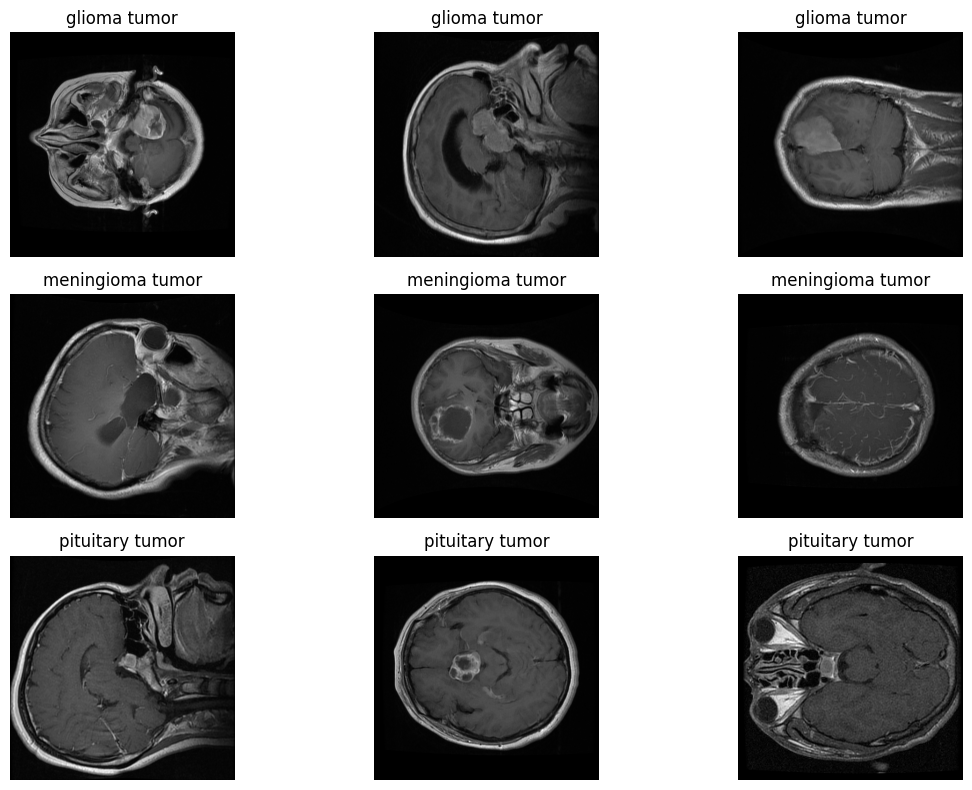

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8))

axs = axs.flatten()

for i, (img, image_name) in enumerate(zip(images_vis, image_names_vis)):
    axs[i].imshow(img, cmap = 'gray')
    axs[i].set_title(image_name)
    axs[i].axis('off')  # Turn off axis for clean visualization

plt.tight_layout()
plt.show()

In [10]:
def Processing(img, msk):
  img_sobel = sobel(img)
  img_sobel[msk] = img_sobel.max()
  img_sobel = cv.resize(img_sobel, (128, 128))
  img_sobel = img_sobel / img_sobel.max()
  return img_sobel

def rotation_90_CLOCKWISE(image):
    return cv.rotate(image, cv.ROTATE_90_CLOCKWISE)

def rotation_90_COUNTERCLOCKWISE(image):
    return cv.rotate(image, cv.ROTATE_90_COUNTERCLOCKWISE)

def rotation_180(image):
    return cv.rotate(image, cv.ROTATE_180)

def horizontal_flip(image):
    return cv.flip(image, 1)

def vertical_flip(image):
    return cv.flip(image, 0)

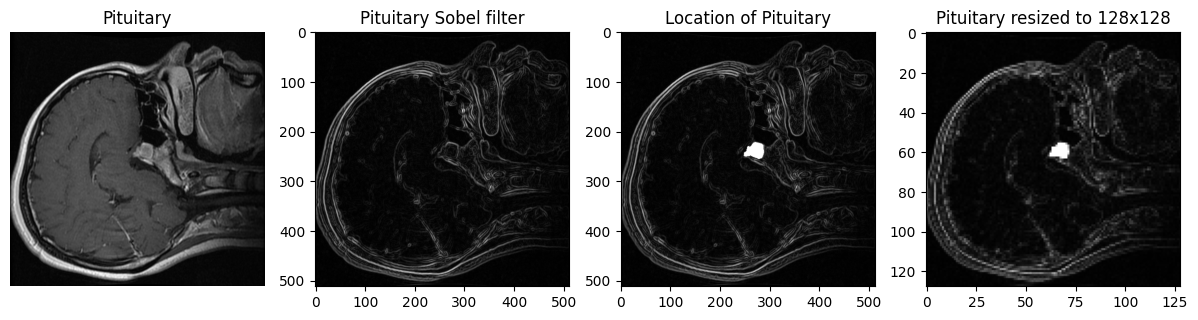

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(12, 8))

axs = axs.flatten()

img = images[0]
axs[0].imshow(img, cmap = 'gray')
axs[0].set_title(classes[labels[0]])


img_sobel = sobel(img)
axs[1].imshow(img_sobel, cmap = 'gray')
axs[1].set_title(f"{classes[labels[0]]} Sobel filter")


img_sobel[masks[0]] = img_sobel.max()
axs[2].imshow(img_sobel, cmap = 'gray')
axs[2].set_title(f"Location of {classes[labels[0]]}")


img_sobel = cv.resize(img_sobel, (128, 128))
axs[3].imshow(img_sobel, cmap = 'gray')
axs[3].set_title(f"{classes[labels[0]]} resized to 128x128")

axs[0].axis('off')  # Turn off axis for clean visualization

plt.tight_layout()
plt.show()

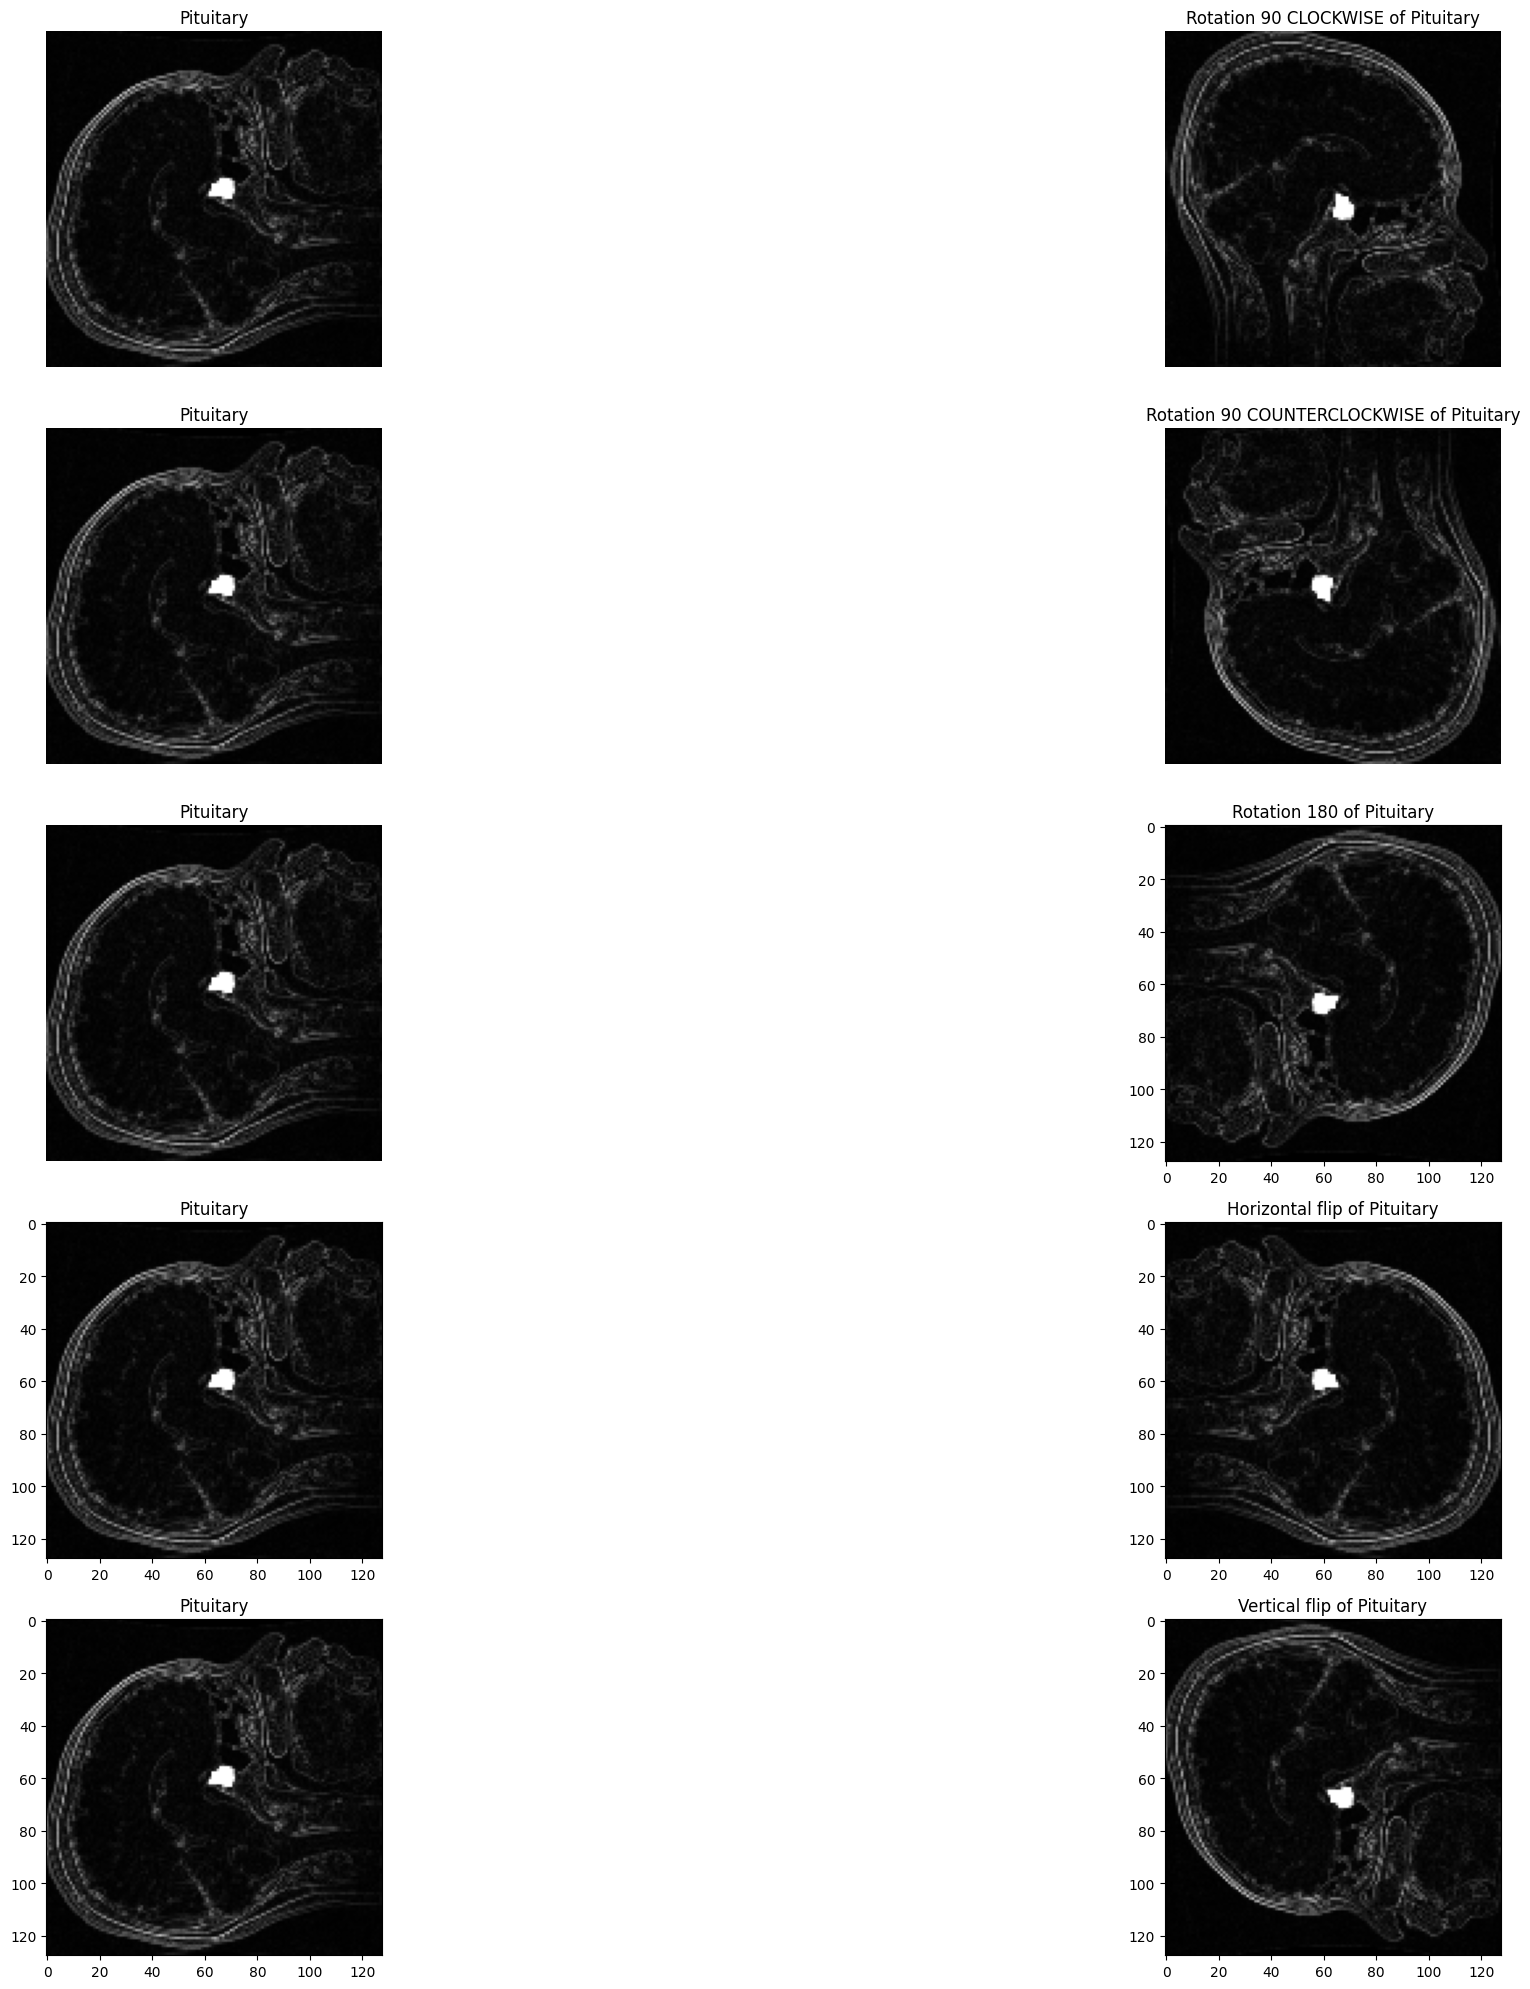

In [12]:
fig, axs = plt.subplots(5, 2, figsize=(30, 20))

axs = axs.flatten()

axs[0].imshow(img_sobel, cmap = 'gray')
axs[0].set_title(f"{classes[labels[0]]}")

axs[1].imshow(rotation_90_CLOCKWISE(img_sobel), cmap = 'gray')
axs[1].set_title(f"Rotation 90 CLOCKWISE of {classes[labels[0]]}")

axs[0].axis('off')  # Turn off axis for clean visualization

axs[2].imshow(img_sobel, cmap = 'gray')
axs[2].set_title(f"{classes[labels[0]]}")

axs[3].imshow(rotation_90_COUNTERCLOCKWISE(img_sobel), cmap = 'gray')
axs[3].set_title(f"Rotation 90 COUNTERCLOCKWISE of {classes[labels[0]]}")

axs[1].axis('off')  # Turn off axis for clean visualization

axs[4].imshow(img_sobel, cmap = 'gray')
axs[4].set_title(f"{classes[labels[0]]}")

axs[5].imshow(rotation_180(img_sobel), cmap = 'gray')
axs[5].set_title(f"Rotation 180 of {classes[labels[0]]}")

axs[2].axis('off')  # Turn off axis for clean visualization

axs[6].imshow(img_sobel, cmap = 'gray')
axs[6].set_title(f"{classes[labels[0]]}")

axs[7].imshow(horizontal_flip(img_sobel), cmap = 'gray')
axs[7].set_title(f"Horizontal flip of {classes[labels[0]]}")

axs[3].axis('off')  # Turn off axis for clean visualization

axs[8].imshow(img_sobel, cmap = 'gray')
axs[8].set_title(f"{classes[labels[0]]}")

axs[9].imshow(vertical_flip(img_sobel), cmap = 'gray')
axs[9].set_title(f"Vertical flip of {classes[labels[0]]}")

axs[4].axis('off')  # Turn off axis for clean visualization

plt.tight_layout()
plt.show()

In [13]:
images_masks = []
labels_I_M = []
for i, (img, msk) in enumerate(zip(images, masks)):
  img_msk = Processing(img, msk)
  images_masks.append(img_msk)
  images_masks.append(rotation_90_CLOCKWISE(img_msk))
  images_masks.append(rotation_90_COUNTERCLOCKWISE(img_msk))
  images_masks.append(rotation_180(img_msk))
  images_masks.append(horizontal_flip(img_msk))
  images_masks.append(vertical_flip(img_msk))
  labels_I_M.append(labels[i])
  labels_I_M.append(labels[i])
  labels_I_M.append(labels[i])
  labels_I_M.append(labels[i])
  labels_I_M.append(labels[i])
  labels_I_M.append(labels[i])

images_masks = np.array(images_masks)
labels_I_M = np.array(labels_I_M)

In [14]:
OHE = OneHotEncoder()
OHE.fit(labels_I_M.reshape(-1, 1))
labels = OHE.transform(labels_I_M.reshape(-1, 1)).toarray()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(images_masks, labels, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [16]:
del images_masks, labels_I_M, images, masks, labels, images_vis, image_names_vis

In [17]:
print(f"Training   : Samples {X_train.shape}, Labels {y_train.shape}")
print(f"Validation : Samples {X_val.shape} , Labels {y_val.shape}")
print(f"Testing    : Samples {X_test.shape} , Labels {y_test.shape}")

Training   : Samples (10294, 128, 128), Labels (10294, 3)
Validation : Samples (4413, 128, 128) , Labels (4413, 3)
Testing    : Samples (3677, 128, 128) , Labels (3677, 3)


In [18]:
model = Sequential([

# Layer 1: Convolutional Layer
Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = (128, 128, 1)),
MaxPooling2D(pool_size=(2, 2)),
BatchNormalization(),

# Layer 2: Convolutional Layer
Conv2D(128, kernel_size=(3, 3), activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
BatchNormalization(),

# Layer 3: Convolutional Layer
Conv2D(256, kernel_size=(3, 3), activation='relu'),
MaxPooling2D(pool_size=(2, 2)),
BatchNormalization(),

# Flatten the feature maps for fully connected layers
Flatten(),

# Layer 4: Fully Connected Layer
Dense(128, activation='relu', kernel_regularizer = l2(0.001)),

# Layer 5: Fully Connected Layer
Dense(64, activation='relu', kernel_regularizer = l2(0.001)),

# Layer 6: Fully Connected Layer
Dense(32, activation='relu', kernel_regularizer = l2(0.001)),

# Output Layer
Dense(3, activation='softmax')
])

# Print a summary of the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                        

In [19]:
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [20]:
Train_hist = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 32, epochs = 50)

Epoch 1/50
322/322 [==============================] - 29s 47ms/step - loss: 0.8110 - accuracy: 0.8113 - val_loss: 7.0318 - val_accuracy: 0.3005
Epoch 2/50
322/322 [==============================] - 12s 39ms/step - loss: 0.5604 - accuracy: 0.9261 - val_loss: 1.4658 - val_accuracy: 0.5704
Epoch 3/50
322/322 [==============================] - 13s 39ms/step - loss: 0.4203 - accuracy: 0.9780 - val_loss: 0.5705 - val_accuracy: 0.9112
Epoch 4/50
322/322 [==============================] - 14s 43ms/step - loss: 0.3507 - accuracy: 0.9962 - val_loss: 0.4998 - val_accuracy: 0.9361
Epoch 5/50
322/322 [==============================] - 13s 40ms/step - loss: 0.3073 - accuracy: 0.9997 - val_loss: 0.4497 - val_accuracy: 0.9456
Epoch 6/50
322/322 [==============================] - 13s 39ms/step - loss: 0.2739 - accuracy: 1.0000 - val_loss: 0.4063 - val_accuracy: 0.9483
Epoch 7/50
322/322 [==============================] - 14s 43ms/step - loss: 0.2433 - accuracy: 1.0000 - val_loss: 0.3761 - val_accuracy:

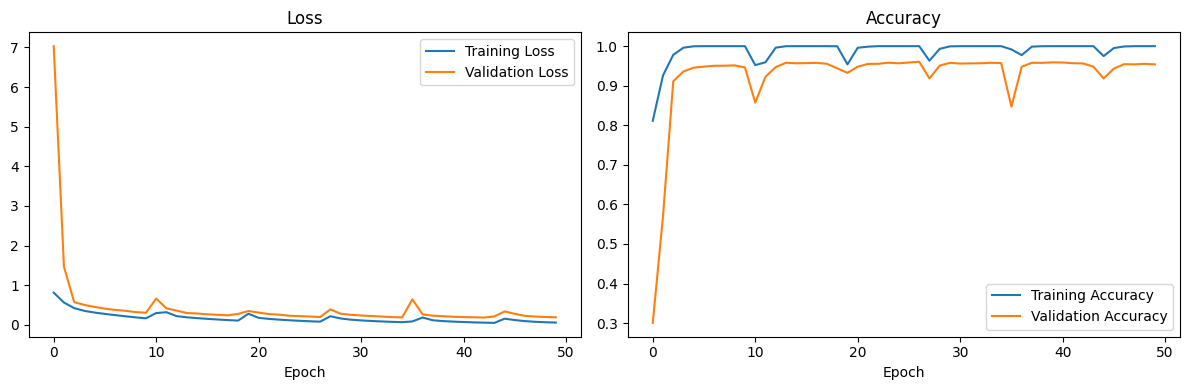

In [21]:
# Access loss and accuracy history
training_loss = Train_hist.history['loss']
validation_loss = Train_hist.history['val_loss']
training_accuracy = Train_hist.history['accuracy']
validation_accuracy = Train_hist.history['val_accuracy']

# Create subplots for loss and accuracy
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
model.load_weights("weights5.h5")

In [23]:
loss, acc = model.evaluate(X_test, y_test)

115/115 [==============================] - 1s 11ms/step - loss: 0.0808 - accuracy: 0.9810


In [24]:
y_pred = model.predict(X_test)
y_pred1 = np.argmax(y_pred, axis = 1)
y_test1 = np.argmax(y_test, axis = 1)

115/115 [==============================] - 1s 10ms/step


In [25]:
print(classification_report(y_test1, y_pred1, digits = 4))
print("Confusion Matrix : ")
print(confusion_matrix(y_test1, y_pred1))


              precision    recall  f1-score   support

           0     0.9629    0.9585    0.9607       867
           1     0.9855    0.9808    0.9832      1667
           2     0.9879    0.9983    0.9930      1143

    accuracy                         0.9810      3677
   macro avg     0.9788    0.9792    0.9790      3677
weighted avg     0.9809    0.9810    0.9809      3677

Confusion Matrix : 
[[ 831   24   12]
 [  30 1635    2]
 [   2    0 1141]]
